# Segmentación de imágenes 2D con redes completamente convolucionales

La __segmentación__ nos permite dividir una imagen, 2D en este caso, en subimagenes identificables.

Algunos métodos clásicos de segmentación son la __umbralización__, el algoritmo __split & merge__, los algoritmos de __rellenado de regiones__, el algoritmo de __watershed__ o los __modelos deformables__.

Los principales métodos de segmentación clásicos están implementados en librerías de Python como OpenCV o Scikit-Image:

https://pypi.org/project/opencv-python/

https://pypi.org/project/scikit-image/

Que se pueden instalar desde los comandos

In [1]:
# !pip install opencv-python
# !pip install scikit-image

Se puede usar un algoritmo K-Medias sobre el dominio (x,y,r,g,b) para segmentar una imagen. Esto ya viene implementado en la libreria kmeans de opencv y podemos ver fácilmente el resultado sobre una imagen

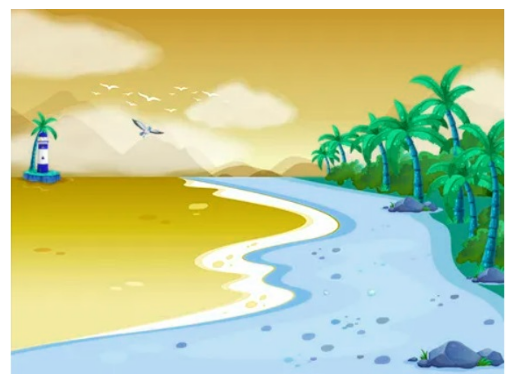

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
img = cv2.imread('data/caribean.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

## Segmentación usando el algoritmo K-means (librería open-cv)

### Preproceso de la imagen

Se preprocesa la imagen convirtiéndola al espacio de color RGB. Se modifica la forma a lo largo del primer eje para convertirla en un vector 2D, es decir, si la imagen tiene la forma (100,100,3) (ancho, alto, canales), se convertirá en (10000,3). Finalmente se convierte en datos flotantes

In [3]:
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
twoDimage = img.reshape((-1,3))
twoDimage = np.float32(twoDimage)

### Definición de los parámetros de K-means

Se definen los criterios por los que se supone que el algoritmo K-means agrupa los píxeles.

La variable 'K' define el número de clústeres/grupos a los que puede pertenecer un píxel (puede aumentar este valor para aumentar el grado de segmentación).

In [4]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
attempts=10

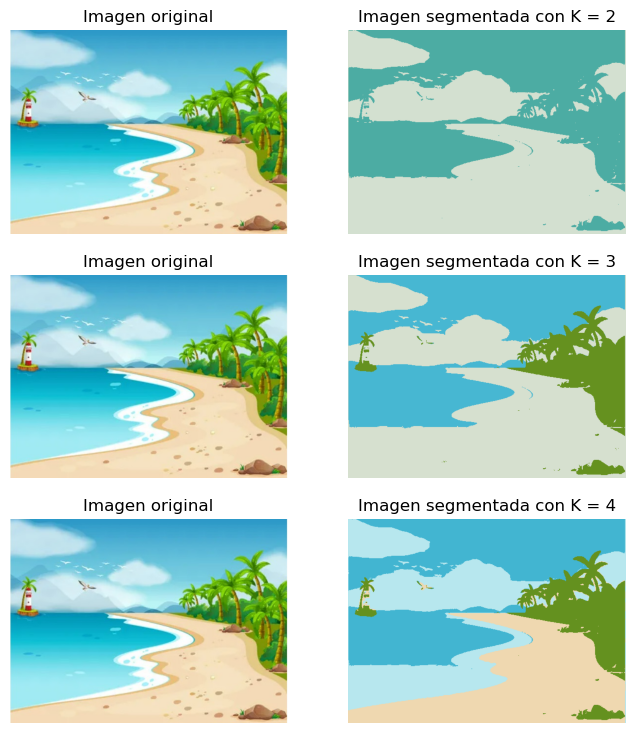

In [5]:
totK=5
fig, axs = plt.subplots(totK-2, 2, figsize=(8,9))
for i in range(2, totK):
    K=i
    ret,label,center=cv2.kmeans(twoDimage,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((img.shape))
    axs[i-2, 0].imshow(img)
    axs[i-2, 0].set_title('Imagen original')
    axs[i-2, 1].imshow(result_image)
    axs[i-2, 1].set_title('Imagen segmentada con K = ' + str(i))
    axs[i-2, 0].axis('off')
    axs[i-2, 1].axis('off')

## Segmentación usando redes neuronales

La __segmentación basada en redes neuronales__ supone disponer de un conjunto de entrenamiento donde tengamos imagenes y esté __anotada la segmentación de cada punto__.

Para __validar__ la segmentación, tiene que haber una segmentación de referencia, lo que se denomina generalmente como un __ground truth__ (o '_etiquetado manual de imágenes_'). Este ground truth se tiene que obtener de forma manual, pintando la silueta de los objetos de interés con un color uniforme. Todo ello resulta un proceso muy tedioso. Este ground truth será comparado con la segmentación realizada por el método de visión artificial, por medio de una serie de métricas que evaluarán la precisión con la que el sistema segmenta.

Se puede plantear una red convolucional para __segmentar__ una imagen, obteniendo otra imagen con los __objetos de interés__ segmentados. 

Para ello se realiza una adaptación a la red convolucional propuesta por {cite:p}`lecun1998gradient` donde las capas convolucionales acaban en una red densa o perceptrón que realiza la puntuación del objeto completo. Aquí se sustituye la red densa o __capa fully connected__ por un nuevo conjunto de capas convolucionales. De forma que se tienen dos bloques, primero un __Encoder__ seguido de un __Decoder__. 

<img src="images/RedFullyConvolutional.png" width="550px">

El __encoder__ reduce la dimensionalidad de la imagen de entrada hasta llegar a un __vector de características__. Por su parte, el decoder utiliza ese vector de características como entrada (que en la figura de abajo se denomina como latent representation) y aumenta poco a poco su dimensionalidad hasta llegar a la imagen de salida, que será la correspondiente a la __segmentación__.
 
<img src="images/RedFullyConvolutional_2.png" width="550px">

La representación del modelo __decoder - encoder__ tiene un aspecto de __U__ por lo que se denominan __redes en U__ o __U-net__.

Siempre está latente el problema de la escasez de datos etiquetados manualmente mencionado antes. Los modelos de aprendizaje profundo necesitan de una enorme cantidad de datos para ser entrenados, en general. 

En los últimos años, se han hecho muchos esfuerzos para solventar ese problema. Para ello, se pueden utilizar estrategias como el __data augmentation__, que básicamente pretende aumentar el tamaño de un conjunto de imágenes de manera artificial, es decir, sin necesidad de añadir ejemplos etiquetados nuevos.

El __data augmentation clásico__ utiliza __transformaciones triviales__ como rotaciones aleatorias, traslaciones o cambios de intensidad de los píxeles, pero cabe destacar que, en los últimos años, ha cobrado mucha importancia la generación de imagen sintética, con las redes generativas antagónicas (GAN) como una de la estrategias más utilizadas para tal fin (IArtificial.net; Martinez J.):

https://www.iartificial.net/redes-neuronales-generativas-adversarias-gans/



https://towardsdatascience.com/creating-and-training-a-u-net-model-with-pytorch-for-2d-3d-semantic-segmentation-model-building-6ab09d6a0862

**En el presente cuaderno se realiza una implementación sencilla con PyTorch de una red U-Net, que es un métodos de segmentación de aprendizaje profundo propuesto por {cite:p}`ronneberger2015u` y {cite:p}`long2015fully`
**. 

Ronneberger por ejemplo propone el modelo para realizar una segmentación de imagenes biomédicas, en concreto la segmentación de estructuras neuronales en pilas microscópicas electrónicas:

<img src="images/RedFullyConvolutional_3.png" width="400px">

Que se resuelve mediante la siguiente arquitectura:

<img src="images/RedFullyConvolutional_4.png" width="500px">

En este ejercicio para solventar el problema de contar con un conjunto de datos con anotaciones para el entrenamiento se utiliza un **simulador de imágenes**.

La segmentación tiene lugar en mapas, uno para cada una de las clases u objetos de interés. Ronneberger segmenta en 2 clases, pero en la simulación se utilizan 6 tipos de objetos (circunferencia, circulo sólido, triangulo y cuadrado sólido y cuadrado con trama), por lo que la dimensión de la salida de la red y de las variables objetivos o target con las anotaciones son 6 mapas de dimensión [192,192]. Puesto que se usan lotes de 25 imágenes, la dimensión de cada sálida será [25, 6, 192, 192]. Las entradas son en los tres canales (R,G,B) por lo que su dimensión es [25, 3, 192, 192]

La arquitectura que se utiliza para resolver el cuaderno está formada por __5 capas de bajada y 5 capas de subida, formando la red en U__. Las __2 primeras capas de bajada utilizan una red residual de 18 subcapas (ResNet18) ya pre-entrenada__ que está disponible en la librería __torchvision.models.resnet18__

## Importación de las librerías necesarias

In [6]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
from torchvision import datasets
from pathlib import Path
from torchvision import transforms
from torchvision import datasets 
from torch.utils.data import DataLoader
from torch.autograd import Variable
import numpy as np

In [7]:
googleColaboratory = False
entrenamiento = False

In [8]:
if googleColaboratory:
    import google as goo
    goo.colab.drive.mount('/content/drive/')
    filename = "/content/drive/My Drive/Colab Notebooks/data/modeloUnet.pt" 
else:
    filename = "data/modeloUnet.pt"

## Dataset empleado

Se emplea un conjunto de imagenes sintéticas simulado

### Opciones de simulación

In [9]:
import numpy as np
import random

def generate_random_data(height, width, count):
    x, y = zip(*[generate_img_and_mask(height, width) for i in range(0, count)])

    X = np.asarray(x) * 255
    X = X.repeat(3, axis=1).transpose([0, 2, 3, 1]).astype(np.uint8)
    Y = np.asarray(y)

    return X, Y

def generate_img_and_mask(height, width):
    shape = (height, width)

    triangle_location = get_random_location(*shape)
    circle_location1 = get_random_location(*shape, zoom=0.7)
    circle_location2 = get_random_location(*shape, zoom=0.5)
    mesh_location = get_random_location(*shape)
    square_location = get_random_location(*shape, zoom=0.8)
    plus_location = get_random_location(*shape, zoom=1.2)

    # Create input image
    arr = np.zeros(shape, dtype=bool)
    arr = add_triangle(arr, *triangle_location)
    arr = add_circle(arr, *circle_location1)
    arr = add_circle(arr, *circle_location2, fill=True)
    arr = add_mesh_square(arr, *mesh_location)
    arr = add_filled_square(arr, *square_location)
    arr = add_plus(arr, *plus_location)
    arr = np.reshape(arr, (1, height, width)).astype(np.float32)

    # Create target masks
    masks = np.asarray([
        add_filled_square(np.zeros(shape, dtype=bool), *square_location),
        add_circle(np.zeros(shape, dtype=bool), *circle_location2, fill=True),
        add_triangle(np.zeros(shape, dtype=bool), *triangle_location),
        add_circle(np.zeros(shape, dtype=bool), *circle_location1),
         add_filled_square(np.zeros(shape, dtype=bool), *mesh_location),
        # add_mesh_square(np.zeros(shape, dtype=bool), *mesh_location),
        add_plus(np.zeros(shape, dtype=bool), *plus_location)
    ]).astype(np.float32)

    return arr, masks

def add_square(arr, x, y, size):
    s = int(size / 2)
    arr[x-s,y-s:y+s] = True
    arr[x+s,y-s:y+s] = True
    arr[x-s:x+s,y-s] = True
    arr[x-s:x+s,y+s] = True

    return arr

def add_filled_square(arr, x, y, size):
    s = int(size / 2)

    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]

    return np.logical_or(arr, logical_and([xx > x - s, xx < x + s, yy > y - s, yy < y + s]))

def logical_and(arrays):
    new_array = np.ones(arrays[0].shape, dtype=bool)
    for a in arrays:
        new_array = np.logical_and(new_array, a)

    return new_array

def add_mesh_square(arr, x, y, size):
    s = int(size / 2)

    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]

    return np.logical_or(arr, logical_and([xx > x - s, xx < x + s, xx % 2 == 1, yy > y - s, yy < y + s, yy % 2 == 1]))

def add_triangle(arr, x, y, size):
    s = int(size / 2)

    triangle = np.tril(np.ones((size, size), dtype=bool))

    arr[x-s:x-s+triangle.shape[0],y-s:y-s+triangle.shape[1]] = triangle

    return arr

def add_circle(arr, x, y, size, fill=False):
    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]
    circle = np.sqrt((xx - x) ** 2 + (yy - y) ** 2)
    new_arr = np.logical_or(arr, np.logical_and(circle < size, circle >= size * 0.7 if not fill else True))

    return new_arr

def add_plus(arr, x, y, size):
    s = int(size / 2)
    arr[x-1:x+1,y-s:y+s] = True
    arr[x-s:x+s,y-1:y+1] = True

    return arr

def get_random_location(width, height, zoom=1.0):
    x = int(width * random.uniform(0.1, 0.9))
    y = int(height * random.uniform(0.1, 0.9))

    size = int(min(width, height) * random.uniform(0.06, 0.12) * zoom)

    return (x, y, size)

### Opciones de ayuda

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_img_array(img_array, ncol=3):
    nrow = len(img_array) // ncol

    f, plots = plt.subplots(nrow, ncol, sharex='all', sharey='all', figsize=(ncol * 4, nrow * 4))

    for i in range(len(img_array)):
        plots[i // ncol, i % ncol]
        plots[i // ncol, i % ncol].imshow(img_array[i])

from functools import reduce
def plot_side_by_side(img_arrays):
    flatten_list = reduce(lambda x,y: x+y, zip(*img_arrays))

    plot_img_array(np.array(flatten_list), ncol=len(img_arrays))

import itertools
def plot_errors(results_dict, title):
    markers = itertools.cycle(('+', 'x', 'o'))

    plt.title('{}'.format(title))

    for label, result in sorted(results_dict.items()):
        plt.plot(result, marker=next(markers), label=label)
        plt.ylabel('dice_coef')
        plt.xlabel('epoch')
        plt.legend(loc=3, bbox_to_anchor=(1, 0))

    plt.show()

def masks_to_colorimg(masks):
    colors = np.asarray([(201, 58, 64), (242, 207, 1), (0, 152, 75), (101, 172, 228),(56, 34, 132), (160, 194, 56)])

    colorimg = np.ones((masks.shape[1], masks.shape[2], 3), dtype=np.float32) * 255
    channels, height, width = masks.shape

    for y in range(height):
        for x in range(width):
            selected_colors = colors[masks[:,y,x] > 0.5]

            if len(selected_colors) > 0:
                colorimg[y,x,:] = np.mean(selected_colors, axis=0)

    return colorimg.astype(np.uint8)

In [11]:
import matplotlib.pyplot as plt
import numpy as np


# Generate some random images
input_images, target_masks = generate_random_data(192, 192, count=3)
numClases=6  ## Se genera cada imagen con 6 objetos de interés

print("input_images shape and range", input_images.shape, input_images.min(), input_images.max())
print("target_masks shape and range", target_masks.shape, target_masks.min(), target_masks.max())

# Change channel-order and make 3 channels for matplot
input_images_rgb = [x.astype(np.uint8) for x in input_images]

# Map each channel (i.e. class) to each color
target_masks_rgb = [masks_to_colorimg(x) for x in target_masks]

input_images shape and range (3, 192, 192, 3) 0 255
target_masks shape and range (3, 6, 192, 192) 0.0 1.0


In [12]:
np.unique(target_masks)

array([0., 1.], dtype=float32)

## A la izquierda imagen de entrada (blanco y negro), A la derecha máscara objetivo (6 clases) 

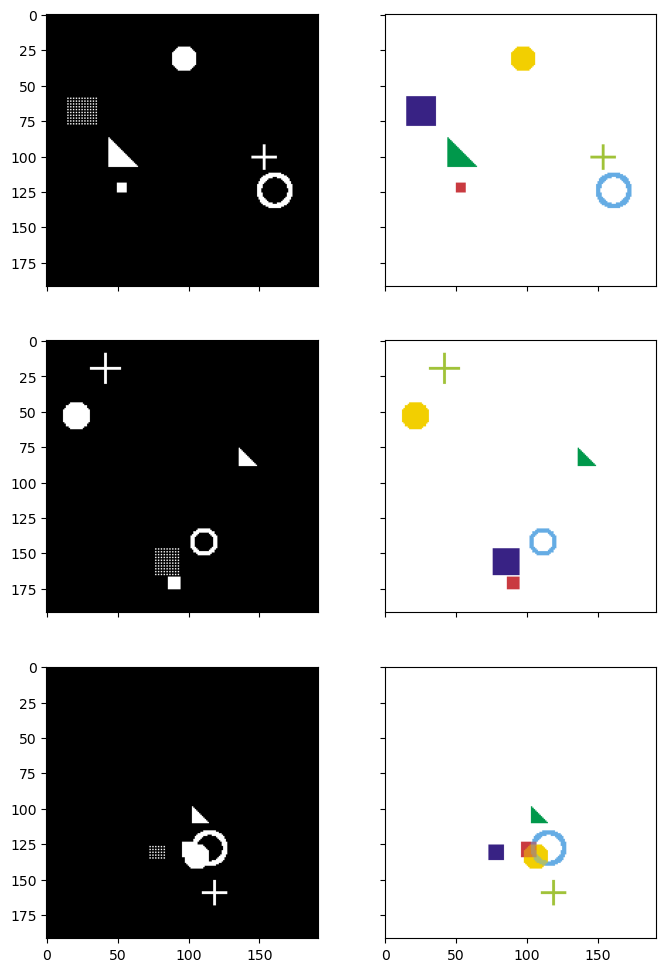

In [13]:
plot_side_by_side([input_images_rgb, target_masks_rgb])

### Preparar Dataset y DataLoader

In [14]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

class SimDataset(Dataset):
  def __init__(self, count, transform=None):
    self.input_images, self.target_masks = generate_random_data(192, 192, count=count)
    self.transform = transform

  def __len__(self):
    return len(self.input_images)

  def __getitem__(self, idx):
    image = self.input_images[idx]
    mask = self.target_masks[idx]
    if self.transform:
      image = self.transform(image)

    return [image, mask]

# use the same transformations for train/val in this example
trans = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

train_set = SimDataset(2000, transform = trans)
val_set = SimDataset(200, transform = trans)

image_datasets = {
  'train': train_set, 'val': val_set
}

batch_size = 25

dataloaders = {
  'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
  'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}



> **Chequear las salidas del DataLoader**



torch.Size([25, 3, 192, 192]) torch.Size([25, 6, 192, 192])


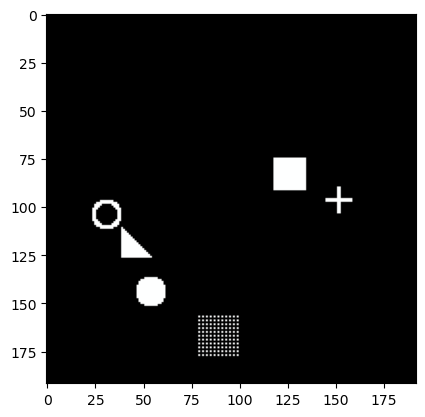

In [15]:
import torchvision.utils

def reverse_transform(inp):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  inp = (inp * 255).astype(np.uint8)

  return inp

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)

plt.imshow(reverse_transform(inputs[3]))

## Modelo U-net

__5 capas de bajada (las 2 primeras basadas en ResNet18) y 5 de subida formando una red U__



In [17]:
import torch.nn as nn
#import torchvision.models
from torchvision.models import resnet18, ResNet18_Weights


def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.ReLU(inplace=True),
  )


class ResNetUNet(nn.Module):
  def __init__(self, n_class):
    super().__init__()

    self.base_model = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
    self.base_layers = list(self.base_model.children())

    self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
    self.layer0_1x1 = convrelu(64, 64, 1, 0)
    self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
    self.layer1_1x1 = convrelu(64, 64, 1, 0)
    self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
    self.layer2_1x1 = convrelu(128, 128, 1, 0)
    self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
    self.layer4_1x1 = convrelu(512, 512, 1, 0)

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    self.conv_original_size0 = convrelu(3, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    self.conv_last = nn.Conv2d(64, n_class, 1)

  def forward(self, input):
    x_original = self.conv_original_size0(input)
    x_original = self.conv_original_size1(x_original)

    layer0 = self.layer0(input)
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)

    layer4 = self.layer4_1x1(layer4)
    x = self.upsample(layer4)
    layer3 = self.layer3_1x1(layer3)
    x = torch.cat([x, layer3], dim=1)
    x = self.conv_up3(x)

    x = self.upsample(x)
    layer2 = self.layer2_1x1(layer2)
    x = torch.cat([x, layer2], dim=1)
    x = self.conv_up2(x)

    x = self.upsample(x)
    layer1 = self.layer1_1x1(layer1)
    x = torch.cat([x, layer1], dim=1)
    x = self.conv_up1(x)

    x = self.upsample(x)
    layer0 = self.layer0_1x1(layer0)
    x = torch.cat([x, layer0], dim=1)
    x = self.conv_up0(x)

    x = self.upsample(x)
    x = torch.cat([x, x_original], dim=1)
    x = self.conv_original_size2(x)

    out = self.conv_last(x)

    return out

### Se crea un objeto Modelo

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if googleColaboratory else torch.device("cpu")
print("device=", device)
model = ResNetUNet(numClases)
model.to(device);

device= cpu


In [19]:
model

ResNetUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [20]:
#!pip install torch-summary

In [21]:
from torchsummary import summary
summary(model, input_size=(3, 192, 192))

Layer (type:depth-idx)                   Param #
├─ResNet: 1-1                            --
|    └─Conv2d: 2-1                       9,408
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─Sequential: 2-5                   --
|    |    └─BasicBlock: 3-1              73,984
|    |    └─BasicBlock: 3-2              73,984
|    └─Sequential: 2-6                   --
|    |    └─BasicBlock: 3-3              230,144
|    |    └─BasicBlock: 3-4              295,424
|    └─Sequential: 2-7                   --
|    |    └─BasicBlock: 3-5              919,040
|    |    └─BasicBlock: 3-6              1,180,672
|    └─Sequential: 2-8                   --
|    |    └─BasicBlock: 3-7              3,673,088
|    |    └─BasicBlock: 3-8              4,720,640
|    └─AdaptiveAvgPool2d: 2-9            --
|    └─Linear: 2-10                      513,000
├─Sequential: 1-2                        --
|    └─Conv2d: 2-1

Layer (type:depth-idx)                   Param #
├─ResNet: 1-1                            --
|    └─Conv2d: 2-1                       9,408
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─Sequential: 2-5                   --
|    |    └─BasicBlock: 3-1              73,984
|    |    └─BasicBlock: 3-2              73,984
|    └─Sequential: 2-6                   --
|    |    └─BasicBlock: 3-3              230,144
|    |    └─BasicBlock: 3-4              295,424
|    └─Sequential: 2-7                   --
|    |    └─BasicBlock: 3-5              919,040
|    |    └─BasicBlock: 3-6              1,180,672
|    └─Sequential: 2-8                   --
|    |    └─BasicBlock: 3-7              3,673,088
|    |    └─BasicBlock: 3-8              4,720,640
|    └─AdaptiveAvgPool2d: 2-9            --
|    └─Linear: 2-10                      513,000
├─Sequential: 1-2                        --
|    └─Conv2d: 2-1

### Método de optimización

In [22]:
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)
# freeze backbone layers
for l in model.base_layers:
  for param in l.parameters():
    param.requires_grad = False
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

### Función de pérdida

Para el cálculo de la pérdida se emplea el **índice de Sørensen-Dice**, que es un coeficiente de similitud de datos (DSC), que toma valores en el rango $[0,1]$. Que si vienen dados por dos conjuntos $X$ e $Y$ se puede expresar (siendo el módulo la cardinalidad):

$$ DSC = \frac{2|X \cap Y|}{|X|+|Y|} $$

Para evitar divisiones por cero es habitual añadir un coeficiente suavizador (smooth) en el numerador y denominador.

La **función de pérdida** se construye entre una media ponderada de
- La función **binary_cross_entropy_with_logit** que mide la entropía cruzada binaria entre el objetivo y los logits de entrada.
- Índice de Sørensen-Dice.

In [23]:
import torch
import torch.nn as nn

def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

In [24]:
def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

In [25]:
def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

## Entrenar el modelo



In [26]:
from collections import defaultdict
num_epochs = 10
best_loss = 1e10

# Train the model
for epoch in range(num_epochs):
    if not entrenamiento:
      print("No habilitada la opción de entrenamiento")
      break
    correct = 0
    total = 0
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    metrics = defaultdict(float)
    epoch_samples = 0
    model.train()
    for i, data in enumerate(dataloaders['train']):
        inputs, labels = data
        assert inputs.size()[2:] == labels.size()[2:]
        N = inputs.size(0)
        #inputs = Variable(inputs).to(device)
        #labels = Variable(labels).to(device)
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        assert outputs.size()[2:] == labels.size()[2:]
        assert outputs.size()[1] == numClases

        loss = calc_loss(outputs, labels, metrics)
        loss.backward()
        optimizer.step()

        epoch_samples += inputs.size(0)

    print_metrics(metrics, epoch_samples, 'train')
    epoch_loss = metrics['loss'] / epoch_samples

    metrics = defaultdict(float)
    epoch_samples = 0
    model.eval()
    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        assert inputs.size()[2:] == labels.size()[2:]
        N = inputs.size(0)
        #inputs = Variable(inputs).to(device)
        #labels = Variable(labels).to(device)
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        assert outputs.size()[2:] == labels.size()[2:]
        assert outputs.size()[1] == numClases

        loss = calc_loss(outputs, labels, metrics)
        epoch_samples += inputs.size(0)

    print_metrics(metrics, epoch_samples, 'test')
    epoch_loss = metrics['loss'] / epoch_samples
    if epoch_loss < best_loss:
        print(f"Salvando el mejor modelo en {filename}")
        best_loss = epoch_loss
        torch.save(model.state_dict(), filename)

            
print ('Final de Entrenamiento')

No habilitada la opción de entrenamiento
Final de Entrenamiento


## Se recupera el modelo entrenado o almacenado

In [27]:
device = torch.device('cpu')
if googleColaboratory:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda
model = ResNetUNet(numClases)
print("Fichero a recuperar=", filename)
model.load_state_dict(torch.load(filename, map_location=torch.device(device))) #recovery trained model
print(model)

Fichero a recuperar= data/modeloUnet.pt
ResNetUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, e

## Se predicen nuevas imagenes usando el modelo entrenado

In [28]:
import math

device = torch.device('cpu')
model.eval()   # Set model to the evaluation mode

# Create a new simulation dataset for testing
test_dataset = SimDataset(3, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)

# Get the first batch
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)
print('inputs.shape', inputs.shape)
print('labels.shape', labels.shape)

# Predict
pred = model(inputs)
# The loss functions include the sigmoid function.
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()
print('pred.shape', pred.shape)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [masks_to_colorimg(x) for x in pred]

inputs.shape torch.Size([3, 3, 192, 192])
labels.shape torch.Size([3, 6, 192, 192])
pred.shape (3, 6, 192, 192)


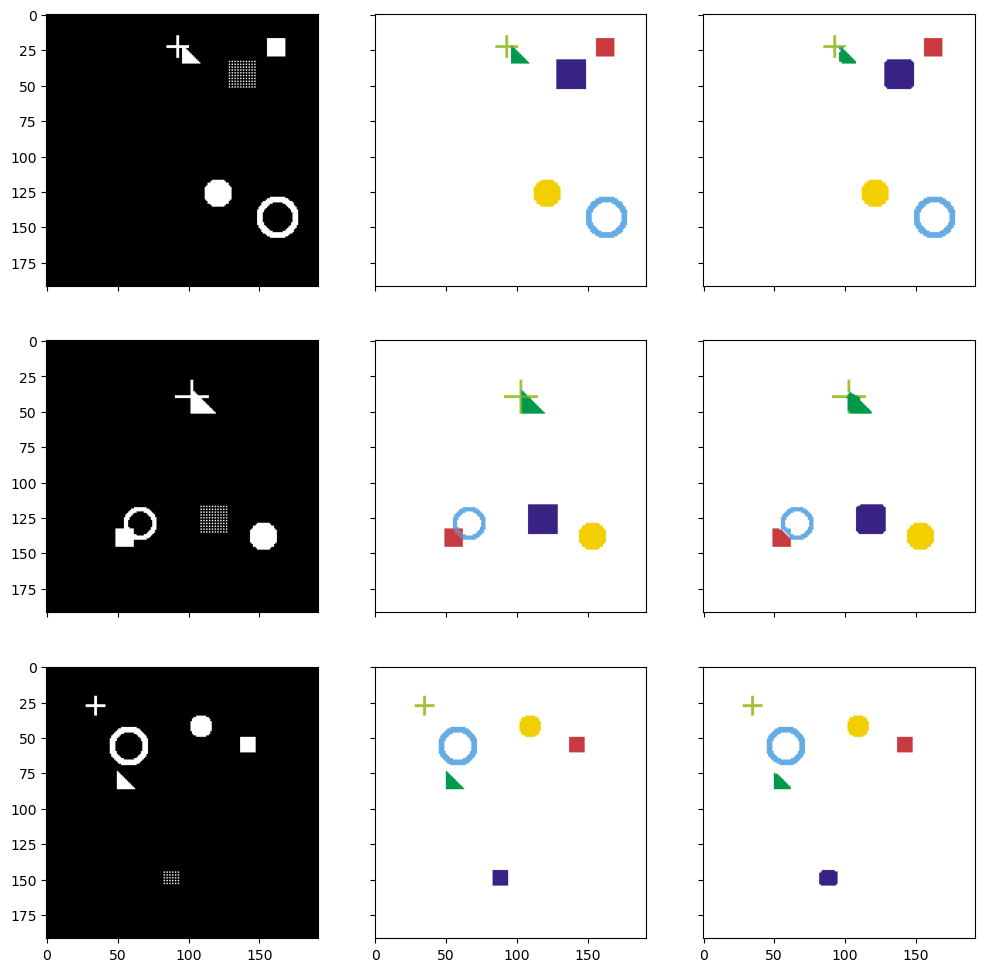

In [29]:
plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])